In [25]:
import pandas as pd
import numpy as np
import MetaTrader5 as mt5 
import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import*
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [26]:
mt5.initialize()

True

In [27]:
symbols ='XAUUSD'
timeframe=mt5.TIMEFRAME_H1
start = 0
finish = 2000

data = mt5.copy_rates_from_pos(symbols , timeframe , start , finish)
data = pd.DataFrame(data)
data['time'] = pd.to_datetime(data['time'] , unit='s')
data

,time,open,high,low,close,tick_volume,spread,real_volume
0,2024-06-06 13:00:00,2361.63,2361.95,2359.49,2361.09,2666,5,0
1,2024-06-06 14:00:00,2361.09,2362.02,2359.23,2359.84,2977,5,0
2,2024-06-06 15:00:00,2359.85,2365.06,2355.32,2357.59,5171,5,0
3,2024-06-06 16:00:00,2357.61,2366.89,2353.44,2360.56,6010,5,0
4,2024-06-06 17:00:00,2360.59,2366.34,2358.60,2364.30,5317,5,0
...,...,...,...,...,...,...,...,...
1995,2024-10-07 13:00:00,2656.52,2658.47,2655.20,2655.39,3919,5,0
1996,2024-10-07 14:00:00,2655.33,2659.61,2655.10,2656.79,4046,6,0
1997,2024-10-07 15:00:00,2656.97,2659.16,2637.74,2640.09,5545,8,0
1998,2024-10-07 16:00:00,2639.86,2653.71,2639.70,2642.70,6154,5,0


In [28]:
data.shape

(2000, 8)

In [29]:
data.describe()

,time,open,high,low,close,tick_volume,spread,real_volume
count,2000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0
mean,2024-08-07 00:46:04.800000,2455.352515,2458.415445,2452.267730,2455.497870,6531.362000,15.680500,0.0
min,2024-06-06 13:00:00,2288.350000,2294.260000,2286.710000,2288.300000,20.000000,5.000000,0.0
25%,2024-07-08 10:45:00,2365.200000,2368.360000,2362.835000,2365.297500,3450.250000,5.000000,0.0
50%,2024-08-07 04:30:00,2444.365000,2447.970000,2441.050000,2444.345000,5690.000000,5.000000,0.0
75%,2024-09-05 23:30:00,2515.732500,2518.022500,2513.052500,2515.780000,8667.750000,33.000000,0.0
max,2024-10-07 17:00:00,2682.680000,2685.440000,2672.160000,2682.670000,21276.000000,33.000000,0.0
std,NaN,106.538993,106.664197,106.469944,106.608537,3971.235332,13.343442,0.0


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         2000 non-null   datetime64[ns]
 1   open         2000 non-null   float64       
 2   high         2000 non-null   float64       
 3   low          2000 non-null   float64       
 4   close        2000 non-null   float64       
 5   tick_volume  2000 non-null   uint64        
 6   spread       2000 non-null   int32         
 7   real_volume  2000 non-null   uint64        
dtypes: datetime64[ns](1), float64(4), int32(1), uint64(2)
memory usage: 117.3 KB


In [31]:
data.isnull().sum()

time           0
open           0
high           0
low            0
close          0
tick_volume    0
spread         0
real_volume    0
dtype: int64

In [32]:
data = data[['open', 'high', 'low', 'close']]
data

,open,high,low,close
0,2361.63,2361.95,2359.49,2361.09
1,2361.09,2362.02,2359.23,2359.84
2,2359.85,2365.06,2355.32,2357.59
3,2357.61,2366.89,2353.44,2360.56
4,2360.59,2366.34,2358.60,2364.30
...,...,...,...,...
1995,2656.52,2658.47,2655.20,2655.39
1996,2655.33,2659.61,2655.10,2656.79
1997,2656.97,2659.16,2637.74,2640.09
1998,2639.86,2653.71,2639.70,2642.70


In [33]:

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [34]:


train_data , test_data = train_test_split(scaled_data , test_size=0.4 , shuffle=False)


In [35]:
def create_dataset(dataset , lookback=1):
    dataX , dataY =[], []
    for i in range(len(dataset)-lookback-1):
        a = dataset[i:(i+lookback), :]
        dataX.append(a)
        dataY.append(dataset[i+lookback,3])
    return np.array(dataX) , np.array(dataY)    

In [36]:
look_back = 30
X_train , Y_train = create_dataset(train_data, look_back)
X_test , Y_test = create_dataset(test_data, look_back)

In [37]:

def create_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [38]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [39]:
model = create_model()
model.fit(X_train, Y_train, batch_size=50, epochs=32)

Epoch 1/32


c:\Users\number_one\Desktop\prog\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0316
Epoch 2/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012
Epoch 3/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.9574e-04
Epoch 4/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.9171e-04
Epoch 5/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.5402e-04
Epoch 6/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.5722e-04
Epoch 7/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.9972e-04
Epoch 8/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.6407e-04
Epoch 9/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.9101e-04
Epoch 10/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.1170e-04
Epoch 11/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.1411e-04
Epoch 12/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.5769e-04
Epoch 13/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.2743e-04
Epoch 14/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.0410e-04
Epoch 15/32
24/24 ━━━━━━━━━━━━━━━━

In [40]:
predictions = model.predict(X_test)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [41]:
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], 3)), predictions), axis=1))[:, 3]
Y_test = scaler.inverse_transform(np.concatenate((np.zeros((Y_test.shape[0], 3)), Y_test.reshape(-1, 1)), axis=1))[:, 3]

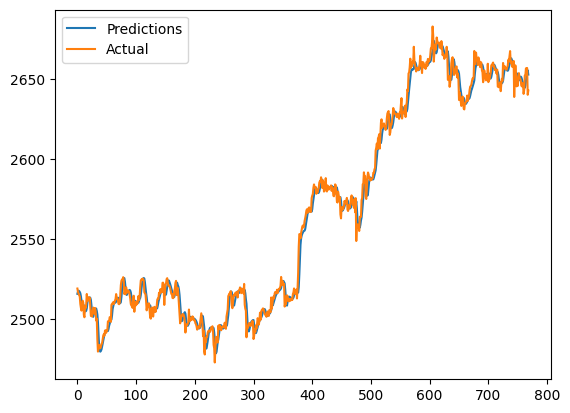

In [45]:

plt.plot(predictions, label = "Predictions")
plt.plot(Y_test, label="Actual")
plt.legend()
plt.show()

In [43]:

rmse = np.sqrt(mean_squared_error(Y_test, predictions))
mae = mean_absolute_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)
mse = mean_squared_error(Y_test, predictions)
mape = mean_absolute_percentage_error(Y_test, predictions)
evs = explained_variance_score(Y_test, predictions)


print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Explained Variance Score:", evs)

Root Mean Squared Error (RMSE): 5.395669014585455
Mean Absolute Error (MAE): 3.930932976566314
R-squared (R²): 0.9930842183995046
Mean Squared Error (MSE): 29.113244114957574
Mean Absolute Percentage Error (MAPE): 0.0015301951795640028
Explained Variance Score: 0.993139751679821


In [44]:

last_look_back_data = scaled_data[-look_back:]
last_look_back_data = np.reshape(last_look_back_data, (1, look_back, last_look_back_data.shape[1]))
predicted_next_candle = model.predict(last_look_back_data)
predicted_next_candle_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((1, 3)), predicted_next_candle), axis=1))[:, 3]
print("Predicted next close price (Candle 2001):", predicted_next_candle_rescaled[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted next close price (Candle 2001): 2645.9574629104136
